# Implémentation article de Yang Song

Article: https://yang-song.net/blog/2021/score/
Application à des Gaussiennes.

## Forward Pass + Visualization

In [42]:
import torch
import torch.optim as optim
from torch import nn
from torch import normal
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [43]:
def show_points(X):
    X = X.cpu()
    nb_points,dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot=0
    for d1 in range(dim):
        for d2 in range(d1+1,dim):
            xs,ys = [],[]
            nb_plot+=1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1,dim**2,nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs,ys)
    plt.show()
    return

def genere_gaussienne(center=(0, 0), sigma=1, nbPoint=1000, dimension=2):
    center = torch.tensor(center,dtype=torch.float).to(device)
    return torch.randn((nbPoint, dimension)).to(device) * sigma + center

def vrai_gradlog(x,center=(0,0),sigma=1,nbPoint=1000,dimension=2):
    center = torch.tensor(center).to(device)
    t= - (x - center)/sigma**2
    return t

After 0 Lanvin MCMC step:


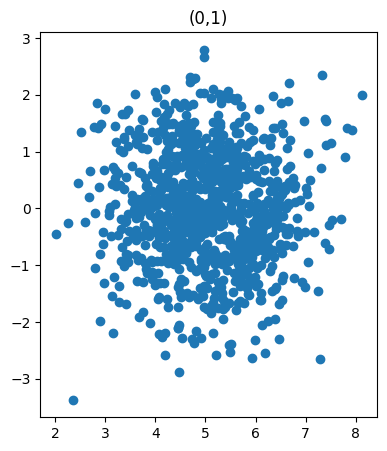

After 100 Lanvin MCMC step:


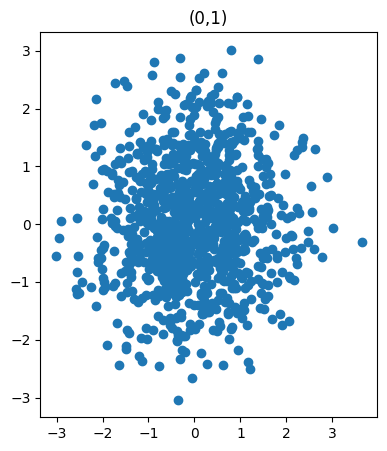

After 200 Lanvin MCMC step:


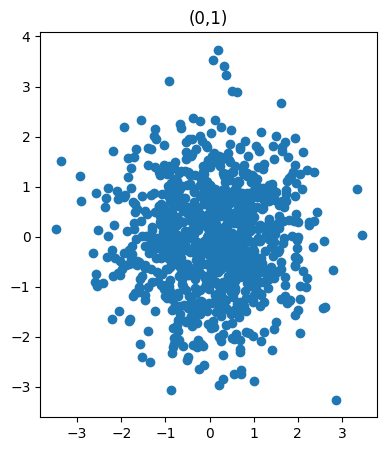

After 300 Lanvin MCMC step:


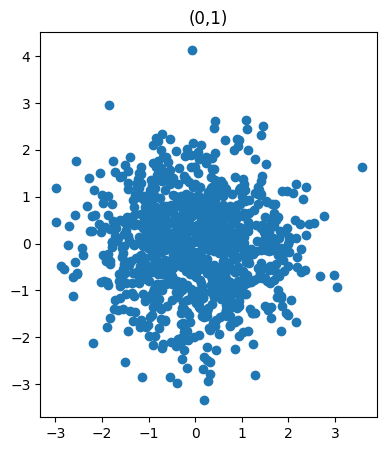

After 400 Lanvin MCMC step:


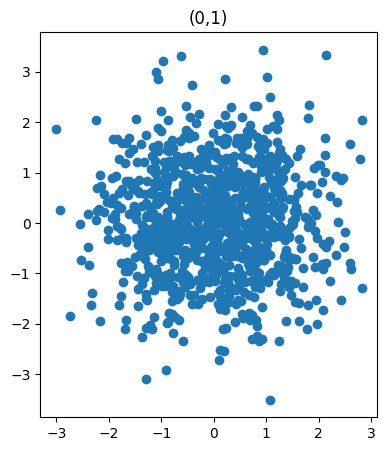

After 500 Lanvin MCMC step:


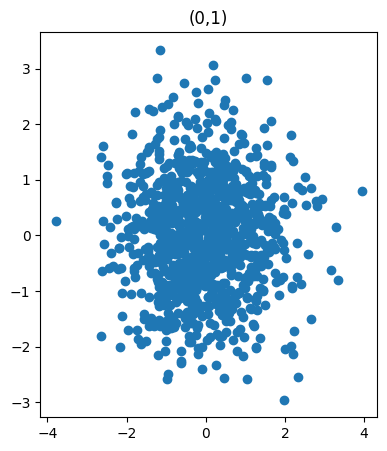

After 600 Lanvin MCMC step:


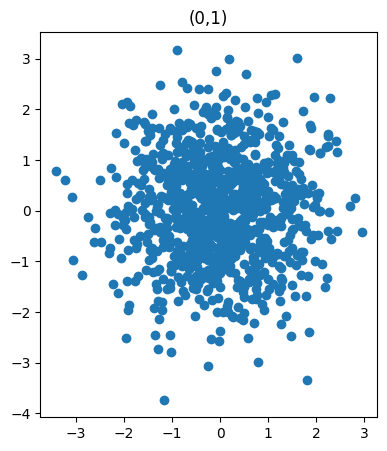

After 700 Lanvin MCMC step:


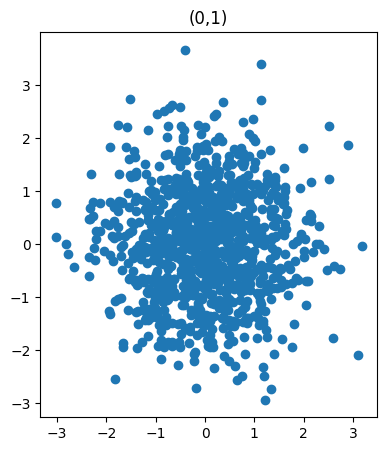

After 800 Lanvin MCMC step:


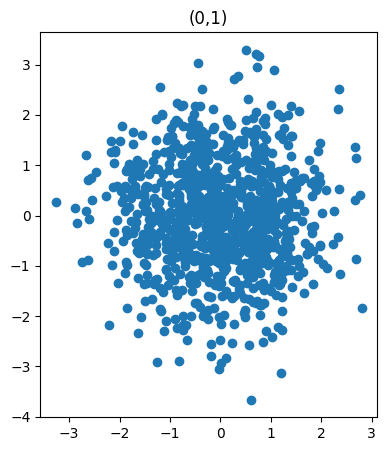

After 900 Lanvin MCMC step:


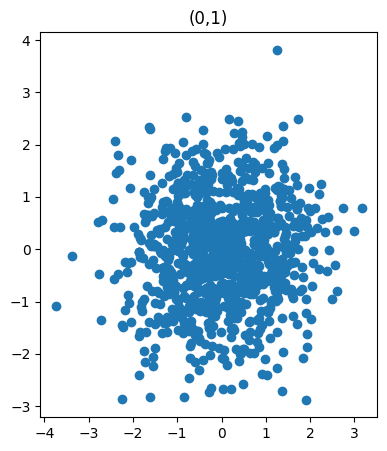

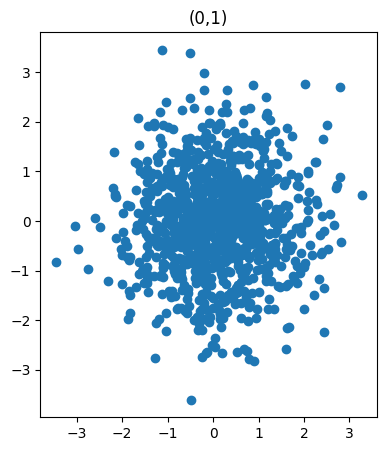

In [44]:
def langevin_one_step(x,epsilon=0.1,center=(0,0),sigma=1,nbPoint = 1000,dim=2):
    vg = vrai_gradlog(x,center,sigma,nbPoint,dim)
    return x + epsilon * vg + sqrt(2 * epsilon) * genere_gaussienne([0 for i in range(dim)],1,nbPoint,dim)

Xs = genere_gaussienne((5,0),1,1000,2)
for i in range(1000):
    if i%100==0:
        print(f"After {i} Lanvin MCMC step:")
        show_points(Xs)
    Xs = langevin_one_step(Xs)
show_points(Xs)

In [74]:
class ScoreModel(nn.Module):
    # Estimation de grad(log(p(x)))
    def __init__(self,inp_dim):
        super(ScoreModel,self).__init__()
        self.fc1 = nn.Linear(inp_dim,128,device=device)
        self.fc2 = nn.Linear(128,inp_dim,device=device)
    def forward(self,x):
        x = x.to(device)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def loss_estimation(x,model):
    # Loss qui ne se sert pas de grad(log(p(x))) ! Cf Obsidian pour les maths.
    x.requires_grad_(True)
    s_theta = model(x)
    s_theta.requires_grad_(True)
    grad_s_theta = torch.autograd.grad(s_theta.sum(),x,retain_graph=True)[0]
    return torch.sum(grad_s_theta) + 0.5 * torch.norm(s_theta)**2

def train(model,dataloader,num_epochs=100,lr=1e-3):
    optimizer = optim.Adam(model.parameters(),lr=lr)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_batch in dataloader:
            optimizer.zero_grad()
            loss = loss_estimation(x_batch,model)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: {total_loss/len(dataloader)}")
Xs = genere_gaussienne((5,0),1,1000,2).to(device)
dataloader = torch.utils.data.DataLoader(Xs,batch_size=32,shuffle=True)
model = ScoreModel(2)
train(model,dataloader,3)

Epoch 0: 7.2272970378398895
Epoch 1: 0.7198288675863296
Epoch 2: -0.3179360335925594


In [75]:
x = genere_gaussienne((5,0),1,1,2)
print(x,vrai_gradlog(x,(5,0),1,1,2),model(x))
y = vrai_gradlog(x,(5,0),1,1,2) - model(x) 
x2 = genere_gaussienne((5,0),1,1,2)
print(vrai_gradlog(x2,(5,0),1,1,2),model(x2)+y)

tensor([[ 5.7247, -0.2771]], device='cuda:0') tensor([[-0.7247,  0.2771]], device='cuda:0') tensor([[-0.0006, -0.0014]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.3403, 0.5413]], device='cuda:0') tensor([[-0.7104,  0.2738]], device='cuda:0', grad_fn=<AddBackward0>)


After 0 Langevin MCMC step:


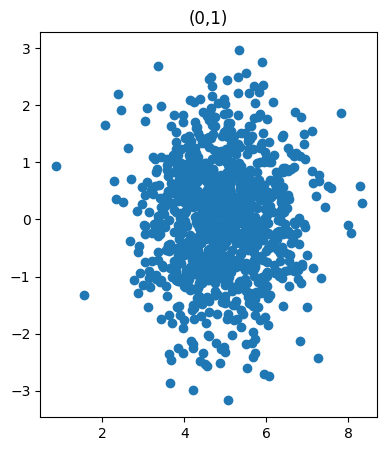

After 100 Langevin MCMC step:


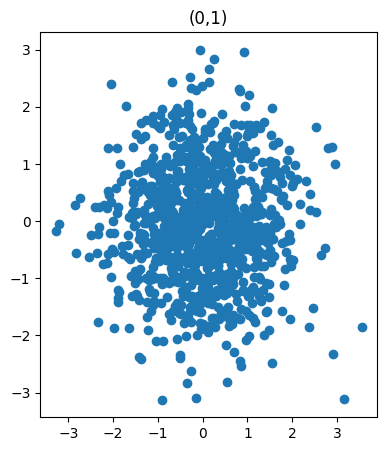

After 200 Langevin MCMC step:


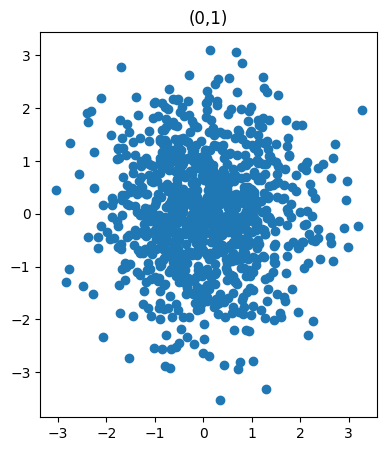

After 300 Langevin MCMC step:


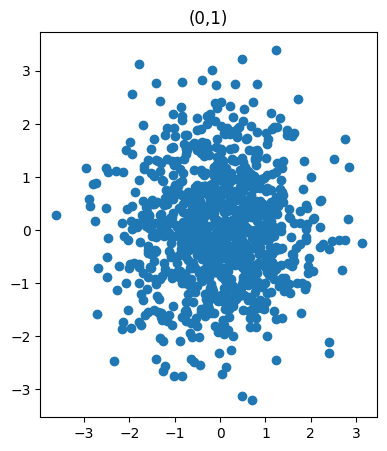

After 400 Langevin MCMC step:


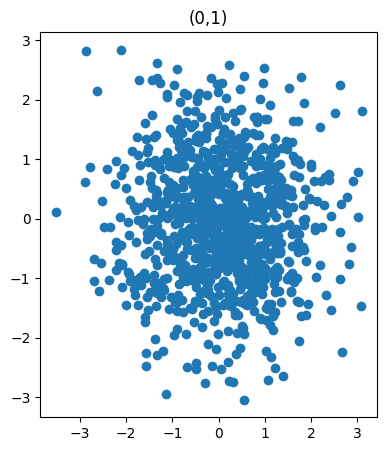

After 500 Langevin MCMC step:


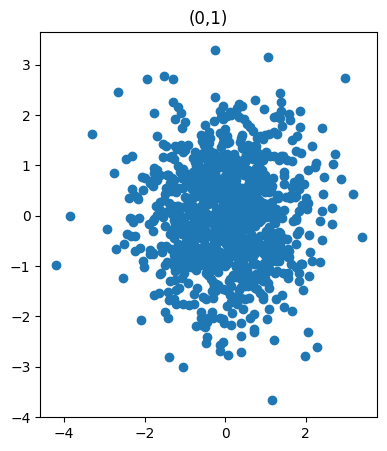

After 600 Langevin MCMC step:


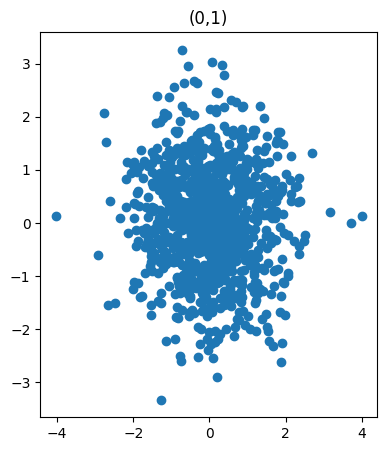

After 700 Langevin MCMC step:


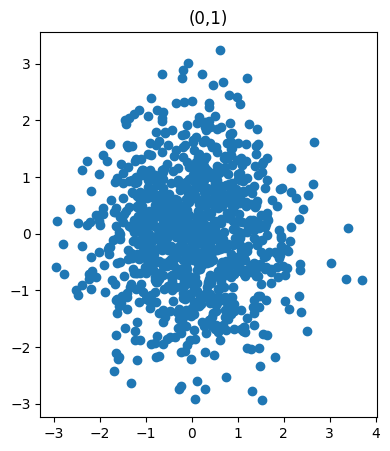

After 800 Langevin MCMC step:


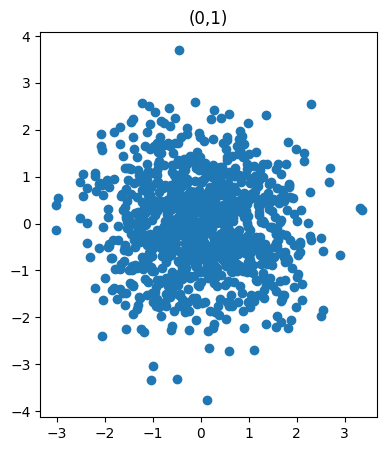

After 900 Langevin MCMC step:


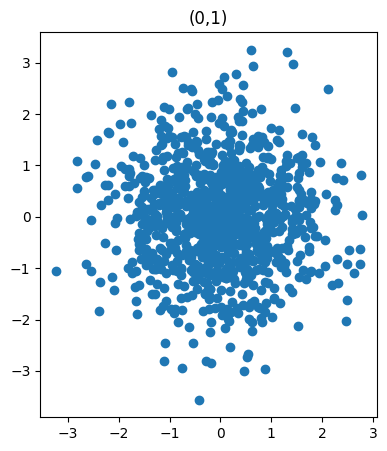

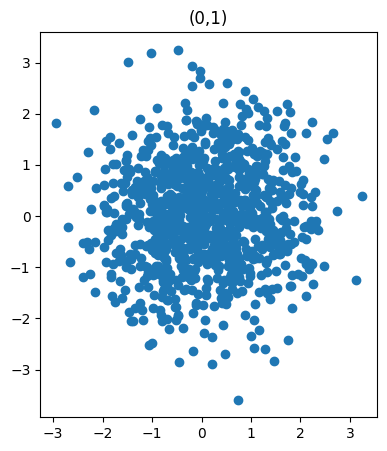

In [77]:
def langevin_one_step_est(x,epsilon=0.1,center=(0,0),sigma=1,nbPoint = 1000,dim=2):
    vg = model(x)
    return x + epsilon * vg + sqrt(2 * epsilon) * genere_gaussienne([0 for i in range(dim)],1,nbPoint,dim)

Xs = genere_gaussienne((5,0),1,1000,2)
for i in range(1000):
    if i%100==0:
        print(f"After {i} Langevin MCMC step:")
        Datas = Xs.detach().cpu()
        show_points(Datas)
    Xs = langevin_one_step(Xs)
show_points(Xs)